<a href="https://colab.research.google.com/github/kmswin1/Pytorch-Study/blob/master/Week1_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab 에서 Pytorch 세팅

In [0]:
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

구글 드라이브 연동

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!mkdir data
!cp -r ./drive/"colab data" ./data
!ls data

In [0]:
!apt-get install -y -qq software-properties-common  module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

라이브러리 로드

In [0]:
import os
import sys
import timeit
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

#plt.rc('text', usetex = True)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "15"

print('python version : ', sys.version)
print('numpy version : ', np.version.version)
print('scipy version : ', sp.__version__)
print('matplotlib version :', mpl.__version__)
print('pytorch version : ', torch.__version__)
print('Cuda : ', torch.cuda.is_available())

python version :  3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
numpy version :  1.14.6
scipy version :  1.1.0
matplotlib version : 2.1.2
pytorch version :  0.4.0
Cuda :  False


Hyperparameter 지정

In [0]:
batchSize = 256
learningRate = 0.01
momentum = 0.9
decay = 5 * 10e-4
epochNum = 80
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cifar-10 / Cifar-100 데이터

In [0]:
dataTrain = torchvision.datasets.CIFAR10(root = './data',
                                         train = True,
                                         download = True,
                                         transform = transforms.ToTensor())

dataTest = torchvision.datasets.CIFAR10(root = './data',
                                         train = False,
                                         download = True,
                                         transform = transforms.ToTensor())

trainLoader = torch.utils.data.DataLoader(dataset = dataTrain, 
                                         batch_size = batchSize, 
                                         shuffle = True)

testLoader = torch.utils.data.DataLoader(dataset = dataTest, 
                                         batch_size = batchSize, 
                                         shuffle = False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


데이터 미리보기

horse   dog truck truck


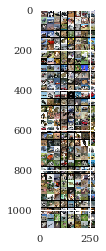

In [0]:
def imshow(img):
  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainLoader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

모델 구현

In [0]:
def conv3x3(inChannel, outChannel, stride = 1):
    
  return nn.Conv2d(inChannel, outChannel, kernel_size = 3, stride = stride, padding = 1, bias = False)

class VGG(nn.Module):
  
  def __init__(self):
    
    super(VGG, self).__init__()
    
    self.conv1 = conv3x3(3, 64)
    self.conv2 = conv3x3(64, 128)
    self.conv3 = conv3x3(128, 256)
    self.conv4 = conv3x3(256, 512)
    self.relu = nn.ReLU(inplace = True)
    self.pool = nn.MaxPool2d(2, stride = 2)
    self.fc1 = nn.Linear(8192, 1024)
    self.fc2 = nn.Linear(1024, 10)
    
    self.batch1 = nn.BatchNorm2d(64)
    self.batch2 = nn.BatchNorm2d(128)
    self.batch3 = nn.BatchNorm2d(256)
    self.batch4 = nn.BatchNorm2d(512)
  
  def forward(self, x):
    
    out = x
    out = self.conv1(out)
    out = self.batch1(out)
    out = self.relu(out)
    out = self.pool(out)
    
    out = self.conv2(out)
    out = self.batch2(out)
    out = self.relu(out)
    out = self.pool(out)
    
    out = self.conv3(out)
    out = self.batch3(out)
    out = self.relu(out)
    out = self.conv4(out)
    out = self.batch4(out)
    out = self.relu(out)
    out = self.pool(out)
    
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    
    return out
  
model = VGG().to(device)

학습 전 테스트

In [0]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

with torch.no_grad():

  correct = 0
  total = 0
  
  for images, labels in testLoader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

학습

In [0]:
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learningRate, momentum = momentum, weight_decay = decay)
optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)

totalStep = len(trainLoader)

for epoch in range(epochNum):
  
    for idx, (images, labels) in enumerate(trainLoader):
      
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (idx + 1) % 100 == 0:
            
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch + 1, epochNum, idx + 1, totalStep, loss.item()))

KeyboardInterrupt: ignored

테스트

In [0]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

with torch.no_grad():

  correct = 0
  total = 0
  
  for images, labels in testLoader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))